# Módulo # 4 - Big Data

## Final Project
## Autor: Jose Martinez

# Input Data

## Probability of winning an Oscar in a movie based on the IMDb and Rotten Tomatoes ratings

### Features Oscar Data Set

- `year_film`: year of the film (integer)
- `year_ceremony`: year of the ceremony (integer)
- `ceremony_name`: name of the ceremony (string)
- `category`: category of the ceremony (string)
- `name`: name of the film (string)
- `film`: name of the film (string)
- `winner`: winner of the ceremony (string)

### Features IMDB Data Set

- `imdb_title_id`: IMDB title id (string)
- `title`: title of the movie (string)
- `original_title`: original title of the movie (string)
- `year`: year of the movie (integer)
- `date_published`: date of publication of the movie (string)
- `genre`: genre of the movie (string)
- `duration`: duration of the movie (integer)
- `country`: country of origin of the movie (string)
- `language`: language of the movie (string)
- `director`: director of the movie (string)
- `writer`: writer of the movie (string)
- `production_company`: production company of the movie (string)
- `actors`: actors of the movie (string)
- `avg_vote`: average vote of the movie (float)
- `votes`: number of votes of the movie (integer)
- `budget`: budget of the movie (float)
- `usa_gross_income`: gross income of the movie in USA (float)
- `worlwide_gross_income`: gross income of the movie in the world (float)
- `metascore`: metascore of the movie (integer)
- `reviews_from_users`: number of reviews from users of the movie (float)
- `reviews_from_critics`: number of reviews from critics of the movie (float)

### Features Rotten Tomatoes Data Set

- `rotten_tomatoes_link`: link to the Rotten Tomatoes page of the movie (string)
- `movie_title`: title of the movie (string)
- `movie_info`: information about the movie (string)
- `critics_consensus`: critics consensus about the movie (string)
- `content_rating`: content rating of the movie (string)
- `genres`: list of genres of the movie (string)
- `directors`: list of directors of the movie (string)
- `authors`: list of authors of the movie (string)
- `actors_rt`: list of actors of the movie (string)
- `original_release_date`: original release date of the movie (string)
- `streaming_release_date`: streaming release date of the movie (string)
- `runtime`: runtime of the movie (integer)
- `production_company_rt`: production company of the movie (string)
- `tomatometer_status`: status of the movie on the tomatometer (string)
- `tomatometer_rating`: rating of the movie on the tomatometer (integer)
- `tomatometer_count`: number of votes of the movie on the tomatometer (integer)
- `audience_status`: status of the movie on the audience (string)
- `audience_rating`: rating of the movie on the audience (integer)
- `audience_count`: number of votes of the movie on the audience (integer)
- `tomatometer_top_critics_count`: number of top critics of the movie on the tomatometer (integer)
- `tomatometer_fresh_critics_count`: number of fresh critics of the movie on the tomatometer (integer)
- `tomatometer_rotten_critics_count`: number of rotten critics of the movie on the tomatometer (integer

### Target Variable

- `winner`: winner of the ceremony (string)

In [1]:
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Bigdata: Model") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/03 21:22:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: float (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: float (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---

# Read data from DB

In [ ]:
from pyspark.ml.feature import VectorAssembler


columns_features = [
    "duration", "director_indexed", "writer_indexed", 
    "production_company_indexed", "actors_indexed", "genre_indexed", 
    "avg_vote", "votes", "reviews_from_users", "reviews_from_critics", 
    "tomatometer_rating", "tomatometer_count", "audience_rating", 
    "audience_count", "tomatometer_top_critics_count", 
    "tomatometer_fresh_critics_count", "tomatometer_rotten_critics_count"
]

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_clean") \
    .load()

df.show()

assembler = VectorAssembler(
    inputCols=columns_features,
    outputCol='Features')

df = assembler.transform(df)
df = df.select(['Features', 'winner_indexed'])
df.show()

# Training the Model

## Split data into training and testing sets

In [10]:
# Split the data into training and test sets (70 % training, 30 % test)
training_df, test_df = df.randomSplit([0.7, 0.3])

# Print the number of observations in the training (label) and test (label) datasets
print(df.count())
print(training_df.count())
print(test_df.count())

14074
9877
4197


## Use the K-fold cross validation

In [11]:
# Codigo tomado de https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import rand
import numpy as np
import collections

TestResult = collections.namedtuple("TestResult", ["params", "metrics"])

class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        folds = []
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()
        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            folds.append([])
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                prediction = model.transform(validation, paramMap)
                metric = eva.evaluate(prediction)
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))
                
                predictionLabels = prediction.select("prediction", "winner_indexed")
                allMetrics = BinaryClassificationMetrics(predictionLabels.rdd)
                folds[i].append(TestResult(paramMap.items(), allMetrics))
                

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics)), folds

## Modelo 1: Regresión Logística 

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('Features', 'winner_indexed')
df.show()

lr = LogisticRegression(featuresCol='Features', labelCol='winner_indexed', maxIter=10)
grid = ParamGridBuilder().addGrid(param=lr.maxIter, values=[10]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=lr,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='winner_indexed'),
                           numFolds=5)

cvlr_model, lr_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1


params: {'maxIter': 10}	areaUnderROC: 0.752572	avg: 0.752572
Comparing models on fold 2


params: {'maxIter': 10}	areaUnderROC: 0.772068	avg: 0.762320
Comparing models on fold 3


params: {'maxIter': 10}	areaUnderROC: 0.778107	avg: 0.767582
Comparing models on fold 4


params: {'maxIter': 10}	areaUnderROC: 0.780993	avg: 0.770935
Comparing models on fold 5


params: {'maxIter': 10}	areaUnderROC: 0.759289	avg: 0.768606


Best model:
params: {'maxIter': 10}	areaUnderROC: 0.768606


## Modelo 2: Random Forest

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('Features', 'winner_indexed')
df.show()

rf = RandomForestClassifier(featuresCol='Features', labelCol='winner_indexed', maxDepth=4)
grid = ParamGridBuilder().addGrid(rf.maxDepth, values=[4]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=rf,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='winner_indexed'),
                           numFolds=5)

cvrf_model, rf_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1
params: {'maxDepth': 4}	areaUnderROC: 0.823172	avg: 0.823172
Comparing models on fold 2
params: {'maxDepth': 4}	areaUnderROC: 0.838866	avg: 0.831019
Comparing models on fold 3
params: {'maxDepth': 4}	areaUnderROC: 0.855573	avg:

## Model 3: Decision Tree

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('Features', 'winner_indexed')
df.show()

dt = DecisionTreeClassifier(featuresCol='Features', labelCol='winner_indexed', maxDepth = 4)
grid = ParamGridBuilder().addGrid(dt.maxDepth, values=[4]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=dt,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='winner_indexed'),
                           numFolds=5)

cvdt_model, dt_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1
params: {'maxDepth': 4}	areaUnderROC: 0.664980	avg: 0.664980
Comparing models on fold 2
params: {'maxDepth': 4}	areaUnderROC: 0.645564	avg: 0.655272
Comparing models on fold 3
params: {'maxDepth': 4}	areaUnderROC: 0.690391	avg:

# Evaluación del conjunto de validación

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import explode, array, lit, col
from pyspark.ml.functions import vector_to_array
import matplotlib.pyplot as plt
import numpy as np

def display_metrics(model):
    # Make predictions on the test set
    predictions = model.transform(test_df.select('Features', 'winner_indexed'))

    # Evaluate the model
    evaluator = BinaryClassificationEvaluator(labelCol='winner_indexed')
    auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("Area under ROC Curve: {:.5f}".format(auroc))
    print("Area under PR Curve: {:.5f}".format(auprc))
    
    evaluator = MulticlassClassificationEvaluator(labelCol='winner_indexed', metricName="accuracy")
    acc = evaluator.evaluate(predictions)
    print("Accuracy: {:.5f}".format(acc))

    return auroc, auprc, acc
    
def save_model(model_name, model):
    
    predictions = model.transform(test_df.select('Features', 'winner_indexed'))
    
    pre_df = (predictions.withColumn("Features", vector_to_array("Features"))).select(["prediction"] + ["winner_indexed"] + [col("Features")[i].alias(columns_features[i]) for i in range(len(columns_features))])    
    pre_df.printSchema()
    
    pre_df \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "testPassword") \
        .option("dbtable", model_name) \
        .save()

## Evaluación y almacenado de modelo 1

Pesos: [-0.053849625232375,-0.2676287377490143,0.8349209435548324,-0.04819933321148136,0.2841071618335499,0.22048830566993,-0.06007775363258871,-0.008039666790305731,-0.48869446283421447,0.012758411033233916]
 b: -2.893638247952581


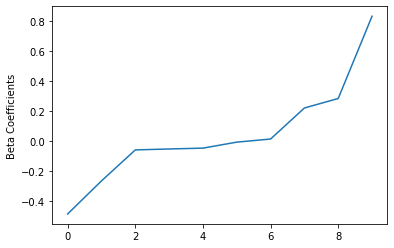

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


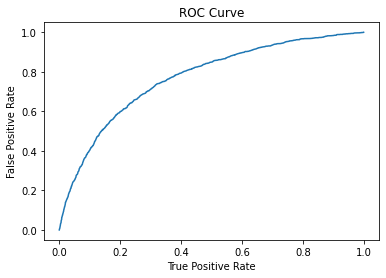

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


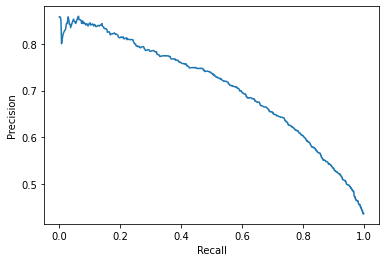

Area under ROC Curve: 0.75755
Area under PR Curve: 0.67929
Accuracy: 0.70241
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



In [16]:
# Crea graficas y analisis de los resultados

# Weights
print('Pesos: {}\n b: {}'.format(cvlr_model.bestModel.coefficients, cvlr_model.bestModel.intercept))

# Coefficients 
beta = np.sort(cvlr_model.bestModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Area under ROC
trainingSummary = cvlr_model.bestModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision and recall.
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
    
cvlr_auroc, cvlr_auprc, cvlr_acc = display_metrics(cvlr_model)

# Guardar modelo en base de datos
save_model("modelo1", cvlr_model)

## Evaluación y almacenado de modelo 2

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


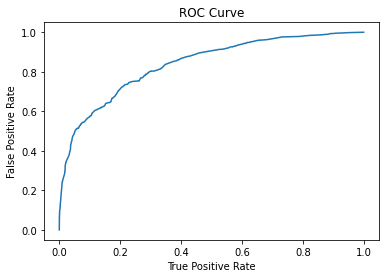

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


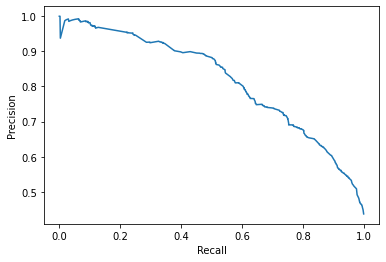

Area under ROC Curve: 0.83502
Area under PR Curve: 0.81061
Accuracy: 0.74744
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



In [17]:
# Area under ROC
trainingSummary = cvrf_model.bestModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision and recall.
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Crea graficas y analisis de los resultados
cvrf_auroc, cvrf_auprc, cvrf_acc = display_metrics(cvrf_model)

# Guardar modelo en base de datos
save_model("modelo2", cvrf_model)

## Evaluación y almacenado de modelo 3

In [18]:
# Crea graficas y analisis de los resultados
cvdt_auroc, cvdt_auprc, cvdt_acc = display_metrics(cvdt_model)

# Guardar modelo en base de datos
save_model("modelo3", cvdt_model)

Area under ROC Curve: 0.61900
Area under PR Curve: 0.62007
Accuracy: 0.74458
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



## Analisis de resultados

Text(0, 0.5, 'Area under ROC Curve')

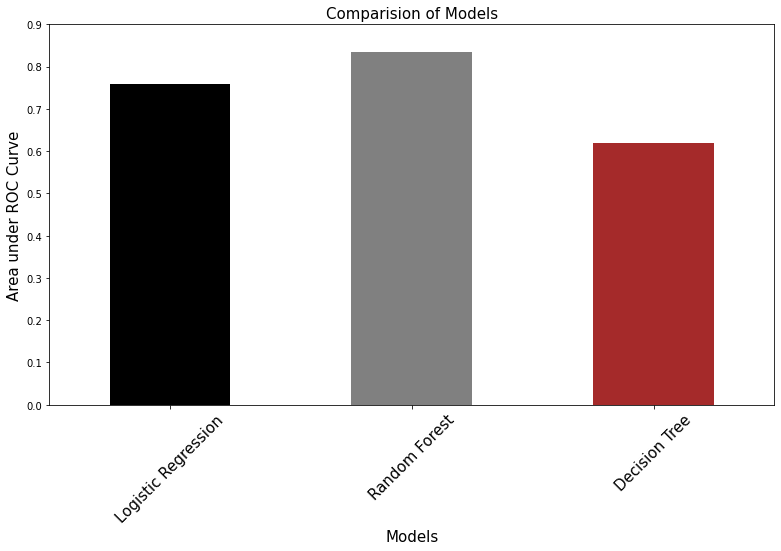

In [19]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_auroc , cvrf_auroc, cvdt_auroc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Area under ROC Curve",fontsize=15)

Text(0, 0.5, 'Area under PR Curve')

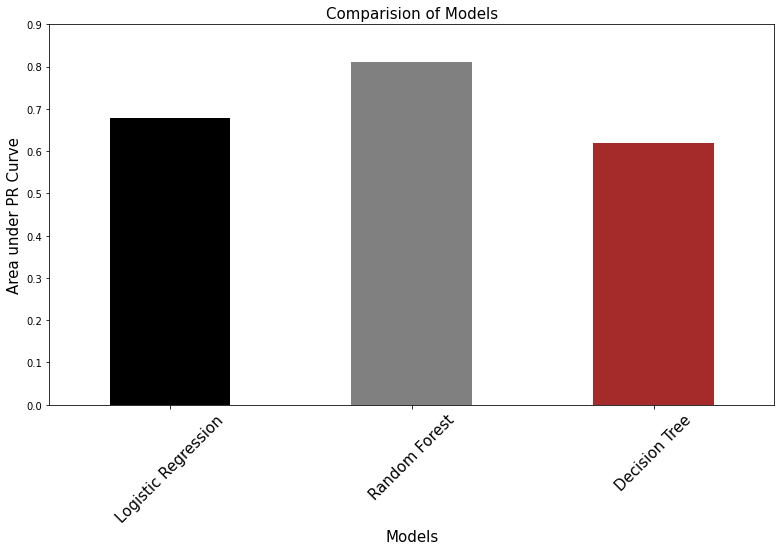

In [20]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_auprc , cvrf_auprc, cvdt_auprc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Area under PR Curve",fontsize=15)

Text(0, 0.5, 'Accuracy')

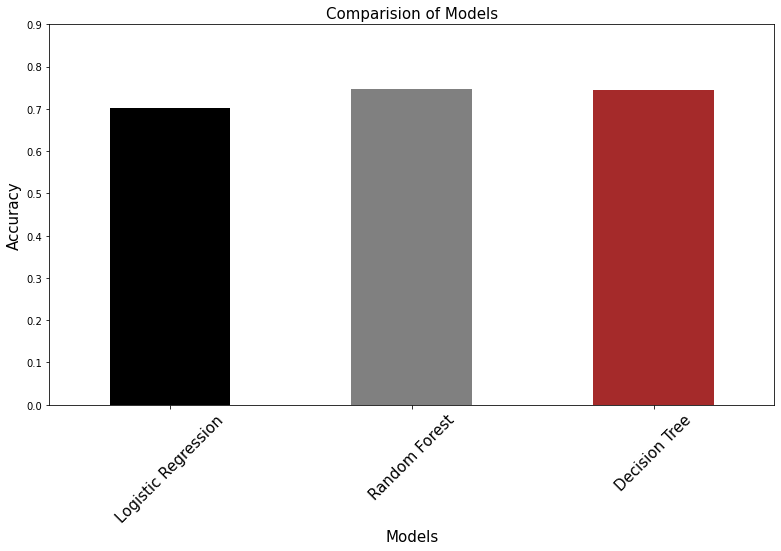

In [21]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_acc , cvrf_acc, cvdt_acc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Accuracy",fontsize=15)

# Modelo 1
En el primer modelo se utilizó una regresión logística para predecir el valor de la variable objetivo. Si se analizan los pesos se puede el feature 'CreditScore' tiene un peso muy alto, por lo que se puede decir que es una variable importante para predecir el valor de la variable objetivo. La grafica de precision-recall tipica de un modelo de regresión logística. 

# Modelo 2
En el segundo modelo se utilizó un Random Forest para predecir el valor de la variable objetivo. Con este modelo se obtuvieron los mejores resultados. En este casio la grafica de precision-recall del modelo 2 muestra que el modelo 2 tiene una precision de 0.9 y un recall de 0.9.

# Modelo 3 
Se creo un modelo adicional, just for fun :). En el tercer modelo se utilizó un Decision Tree para predecir el valor de la variable objetivo. Con este modelo se obtuvieron los peores resultados.

# Conclusiones

Al realizar la comparacion de los modelos, se puede observar que el modelo 3 es el mejor, el modelo 1 es el segundo mejor y el modelo 3 es el tercero mejor. Para este caso el modelo de Random Forest dio los mejores resultados. En todos los casos se realizo un modelo de k-fold cross validation, para obtener una mejor precisión. En la iteracion de los folds, se esta imprimiendo el AUROC y es interesante observar cambia el valor de AUROC en cada iteración. 